In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
#print(pybamm.__version__)
param=pybamm.ParameterValues("Chen2020")


In [2]:
param=pybamm.ParameterValues("Chen2020")
param['Initial inner SEI thickness [m]']=1e-13
param['Initial outer SEI thickness [m]']=1e-13
#param['Inner SEI open-circuit potential [V]']=0.25
param

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008 at 0x7fb7e366f6d0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008 at 0x7fb7e366f640>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initial conce

In [3]:
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 10,  # negative particle
    "r_p": 20,  # positive particle
}

In [4]:
cycle_number =3
exp = pybamm.Experiment(
    [("Charge at C/10 until 4.2 V",
       "Rest for 10 hours",
     "Discharge at C/10 until 2.5 V",
     "Rest for 10 hours")] *cycle_number
#      +[("Charge at 0.3C  until 4.2 V", 
#       "Rest for 2 hours", 
#       "Discharge at 0.7C until 2.5 V", 
#        "Rest for 2 hours")]* cycle_number
)
#print((exp))
#print(exp.operating_conditions_cycles)
#print(exp.convert_time_to_seconds)
pybamm.lithium_ion.DFN().variable_names()

['Time [s]',
 'Time [min]',
 'Time [h]',
 'x [m]',
 'x_n [m]',
 'x_s [m]',
 'x_p [m]',
 'r_n [m]',
 'r_p [m]',
 'Current variable [A]',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Throughput capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Separator porosity',
 'X-averaged separator porosity',
 'Positive electrode porosity',
 'X-averaged positive electrode porosity',
 'Porosity change',
 'Negative electrode porosity change [s-1]',
 'X-averaged negative electrode porosity change [s-1]',
 'Separator porosity change [s-1]',
 'X-averaged separator porosity change [s-1]',
 'Positive electrode porosity change [s-1]',
 'X-averaged positive electrode porosity change [s-1]',
 'Negative electrode interface utilisation variable',
 'X-averaged negative electrode interface utilisation variable',
 'Negative electrode interface utilisation',


In [5]:
#SEIModels=["reaction limited", "solvent-diffusion limited", "interstitial-diffusion limited" , "ec reaction limited"]
#SEIModels=["reaction limited", "solvent-diffusion limited", "interstitial-diffusion limited"]
SEIModels=["reaction limited"];
#t_eval = np.linspace(0, 4600, 600) # time in seconds
# maximum t val is 3600? don't know why? 
#for ii in np.arange(0.2,0.3,0.3):
models=[];
solutions=[]
for index in range(len(SEIModels)):
    models.append (pybamm.lithium_ion.SPMe(
    { "SEI": SEIModels[index],
    "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions
    }))
    #"x-average side reactions": "true"
     #sim = pybamm.Simulation(models[index], parameter_values=param, experiment=exp, var_pts=var_pts)
    solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6)
    #solver = pybamm.IDAKLUSolver()
    sim = pybamm.Simulation(models[index], parameter_values=param,  var_pts=var_pts, experiment=exp,  solver=solver)
    solutions.append(sim.solve(initial_soc=0))

In [6]:
pybamm.dynamic_plot(solutions, output_variables=["X-averaged inner SEI thickness [m]", 
                     "X-averaged SEI film overpotential [V]" ,"Electrolyte potential [V]",
                                                 "X-averaged SEI film overpotential [V]" , 
                                                 "Discharge capacity [A.h]",
                                                "Terminal voltage [V]", "Power [W]",
                                                    ], 
                    labels=SEIModels,variable_limits='tight')

interactive(children=(FloatSlider(value=0.0, description='t', max=119.95470261965863, step=1.1995470261965864)…

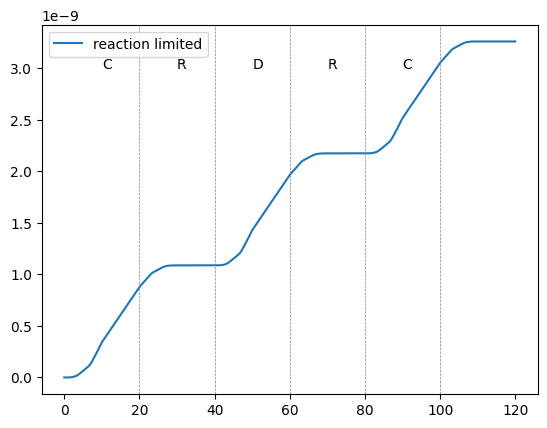

In [7]:
for index in range(len(solutions)):
    tt=solutions[index]["Time [h]"].entries
    xx=solutions[index]["X-averaged inner SEI thickness [m]"].entries
    plt.plot(tt,xx, label=SEIModels[index])
plt.legend()
a = np.sign(solutions[0]["Power [W]"].entries)
pp=solutions[0]["Power [W]"].entries
tt=solutions[0]["Time [h]"].entries
SS=["C", "R", "D", "R"]
for ii in np.arange(20,tt[-1],20):
     plt.axvline(x=ii, color='gray', linewidth=0.5, linestyle="dashed" ) # red line at x=5
     jj=(np.remainder((ii//20-1) , 4)).astype(int)
     plt.annotate(SS[jj], xy=(ii-10, 1e-9), xytext=(ii-10, 3e-9))  

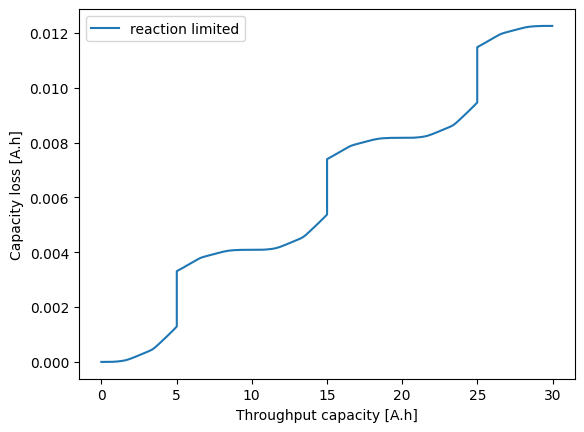

In [8]:
for index in range(len(solutions)):
    tt=solutions[index]["Time [h]"].entries
    Qt = solutions[index]["Throughput capacity [A.h]"].entries
    Q_SEI = solutions[index]["Loss of capacity to SEI [A.h]"].entries
    plt.plot(Qt, Q_SEI,label=SEIModels[index])
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

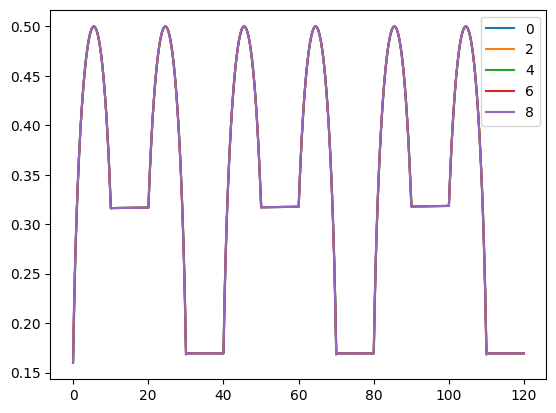

In [9]:
tt=solutions[0]["Time [h]"].entries
Qt = solutions[0]["Negative electrode exchange current density [A.m-2]"].entries
cnn = solutions[0]['Negative particle concentration'].entries
cce = solutions[0]["Electrolyte concentration concatenation [mol.m-3]"].entries
for ii in np.arange(0,10,2):
    plt.plot(tt,np.sqrt(cnn[ii,3,:]*(1-cnn[ii,3,:])), label=ii)
plt.legend()
plt.show()



In [10]:
np.shape(cnn)
F=param['Faraday constant [C.mol-1]']
mn=6.48*1e-7
an=3.84*1e5
ce_int=4541.0
cn_Max=33133.0
i0=4.5/100
L=8.52e-05+7.56e-05+1.2e-05
t0=F*cn_Max*L/i0
Crn=F/(mn*np.sqrt(ce_int)*t0)


In [11]:
i0 = solutions[0]['Current [A]'].entries
np.shape(i0)
# for ii in np.arange(0,10,2):
#     plt.plot(tt,cnn[ii,3,:], label=ii)
# plt.legend()
# plt.show()

(7212,)

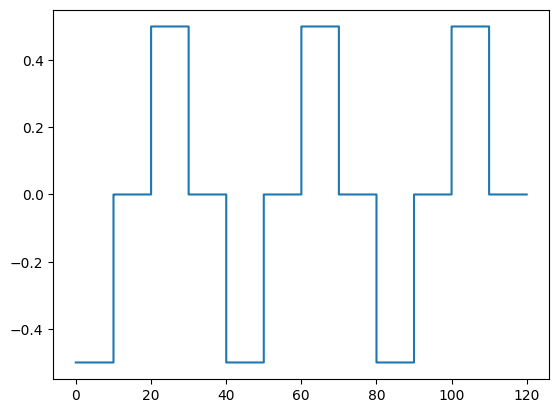

In [12]:
plt.plot(tt,i0)

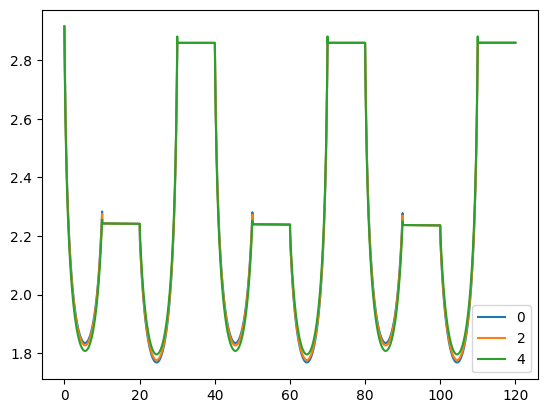

In [13]:
tt=solutions[0]["Time [h]"].entries
cnn = solutions[0]['Negative electrode exchange current density [A.m-2]'].entries
# np.shape(cnn)
# plt.plot(tt,np.sqrt(cnn*(1-cnn)), label=ii)
# plt.legend()
# plt.show()
# np.shape(cnn)
for ii in np.arange(0,5,2):
    plt.plot(tt,np.arcsinh(1/cnn[ii,:]), label=ii)
plt.legend()
plt.show()